# Ada Loss

100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 656kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.18MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 400kB/s]


Epoch: 1, Loss: 2.9727
Epoch: 2, Loss: 0.6824
Epoch: 3, Loss: 0.4233
Epoch: 4, Loss: 0.2909
Epoch: 5, Loss: 0.1901
Epoch: 6, Loss: 0.1542
Epoch: 7, Loss: 0.1154
Epoch: 8, Loss: 0.0858
Epoch: 9, Loss: 0.0915
Epoch: 10, Loss: 0.0681


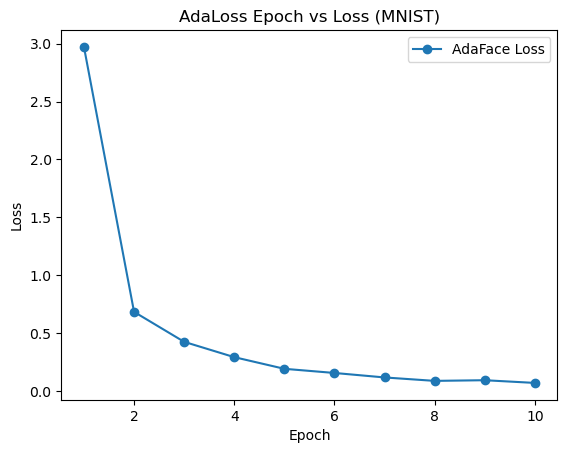

Accuracy: 99.11%


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# AdaFace Loss Function
class AdaFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, s=64.0, m=0.4, h=0.33):
        super(AdaFaceLoss, self).__init__()
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.h = h
        self.weight = nn.Parameter(torch.randn(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        W = F.normalize(self.weight, p=2, dim=1)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        logits = torch.matmul(embeddings, W.T)

        norms = embeddings.norm(p=2, dim=1, keepdim=True)
        norm_mean = norms.mean().detach()
        norm_std = norms.std().detach() + 1e-7
        quality_factor = ((norms - norm_mean) / (norm_std / self.h)).clamp(-1, 1).detach()

        angular_margin = -self.m * quality_factor
        additive_margin = self.m * quality_factor + self.m

        theta = torch.acos(logits.clamp(-0.9999, 0.9999))
        target_logits = torch.cos(theta + angular_margin) - additive_margin

        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)
        logits = logits * (1 - one_hot) + target_logits * one_hot
        logits *= self.s

        return F.cross_entropy(logits, labels)

# CNN for MNIST
class AdaFaceCNN(nn.Module):
    def __init__(self, embedding_size=128, num_classes=10):
        super(AdaFaceCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 14 * 14, 256)  # Adjusted input size to 12544
        self.fc2 = nn.Linear(256, embedding_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor to shape (batch_size, 12544)
        x = F.relu(self.fc1(x))
        return F.normalize(self.fc2(x), p=2, dim=1)

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize Model, Loss, and Optimizer
model = AdaFaceCNN()
criterion = AdaFaceLoss(num_classes=10, embedding_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variable to store AdaLoss data (epoch, loss)
AdaLoss_MNIST = []  # List to store (epoch, loss) for each epoch

# Training Loop with Visualization
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            embeddings = model(images)
            loss = criterion(embeddings, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        AdaLoss_MNIST.append((epoch + 1, avg_loss))  # Store (epoch, loss) in AdaLoss_MNIST
        print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")

    # Plot Loss
    plot_loss(AdaLoss_MNIST)

def plot_loss(loss_data):
    epochs, losses = zip(*loss_data)  # Unzip the list of (epoch, loss) into two separate lists
    plt.plot(epochs, losses, marker='o', label='AdaFace Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("AdaLoss Epoch vs Loss (MNIST)")
    plt.legend()
    plt.show()

# Evaluate Accuracy
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            embeddings = model(images)
            predictions = torch.argmax(torch.matmul(embeddings, criterion.weight.T), dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")

# Run Training and Evaluation
train(model, train_loader, criterion, optimizer)
evaluate(model, test_loader)


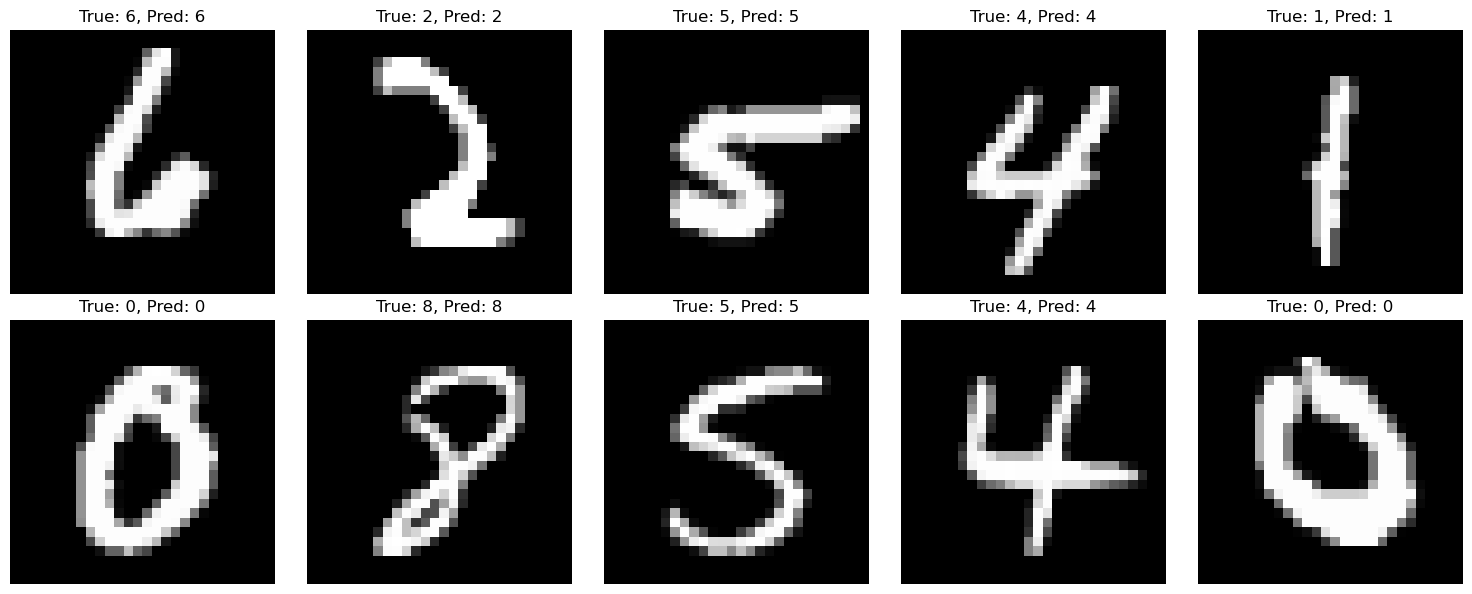

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Function to display 10 random images from the test set along with their predicted labels
def display_random_samples(model, test_loader, num_samples=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Create a 2x5 grid for images
    axes = axes.flatten()

    for i in range(num_samples):
        # Get a random sample from the test set
        random_idx = random.randint(0, len(test_loader.dataset) - 1)
        image, label = test_loader.dataset[random_idx]
        image = image.unsqueeze(0)  # Add batch dimension

        # Get the model's prediction for this sample
        with torch.no_grad():
            embeddings = model(image)
            logits = torch.matmul(embeddings, criterion.weight.T)
            predicted_label = torch.argmax(logits, dim=1).item()

        # Display the image
        axes[i].imshow(image.squeeze(), cmap="gray")
        axes[i].set_title(f"True: {label}, Pred: {predicted_label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to display 10 random samples
display_random_samples(model, test_loader)


100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:04<00:00, 36.8MB/s]


Epoch: 1, Loss: 24.3321
Epoch: 2, Loss: 17.9760
Epoch: 3, Loss: 13.9888
Epoch: 4, Loss: 10.3555
Epoch: 5, Loss: 7.1057
Epoch: 6, Loss: 4.6084
Epoch: 7, Loss: 2.9868
Epoch: 8, Loss: 2.1183
Epoch: 9, Loss: 1.6258
Epoch: 10, Loss: 1.2545
Epoch: 11, Loss: 1.0279
Epoch: 12, Loss: 0.8950
Epoch: 13, Loss: 0.8011
Epoch: 14, Loss: 0.7942
Epoch: 15, Loss: 0.6622
Epoch: 16, Loss: 0.5965
Epoch: 17, Loss: 0.5279
Epoch: 18, Loss: 0.5346
Epoch: 19, Loss: 0.4774
Epoch: 20, Loss: 0.4793


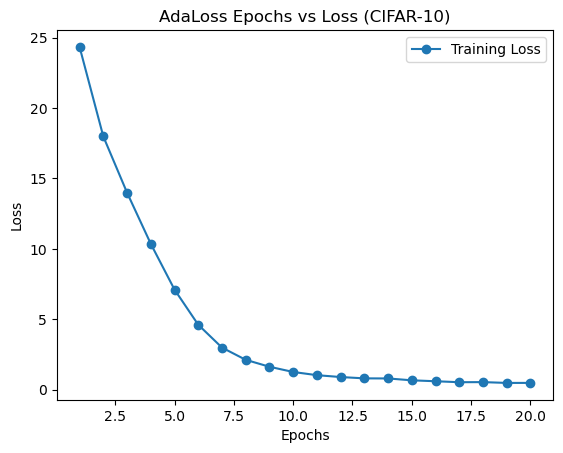

Accuracy: 68.13%


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# AdaFace Loss Function
class AdaFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, s=64.0, m=0.4, h=0.33):
        super(AdaFaceLoss, self).__init__()
        self.num_classes = num_classes
        self.s = s  # Scaling factor
        self.m = m  # Margin parameter
        self.h = h  # Concentration factor
        self.weight = nn.Parameter(torch.randn(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        # Normalize embeddings and weights
        W = F.normalize(self.weight, p=2, dim=1)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        logits = torch.matmul(embeddings, W.T)  # Cosine similarity

        # Compute feature norms
        norms = embeddings.norm(p=2, dim=1, keepdim=True)
        norm_mean = norms.mean().detach()
        norm_std = norms.std().detach() + 1e-7
        quality_factor = ((norms - norm_mean) / (norm_std / self.h)).clamp(-1, 1).detach()

        # Compute adaptive margin
        angular_margin = -self.m * quality_factor
        additive_margin = self.m * quality_factor + self.m

        # Modify logits
        theta = torch.acos(logits.clamp(-0.9999, 0.9999))
        target_logits = torch.cos(theta + angular_margin) - additive_margin

        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)
        logits = logits * (1 - one_hot) + target_logits * one_hot
        logits *= self.s  # Scale logits

        return F.cross_entropy(logits, labels)

# CNN Model for CIFAR-10
class AdaFaceCNN(nn.Module):
    def __init__(self, embedding_size=128, num_classes=10):
        super(AdaFaceCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Adjust fc1 to match the flattened feature size from conv2 and pooling
        self.fc1 = nn.Linear(64 * 16 * 16, 256)  # 64*16*16 = 16384
        self.fc2 = nn.Linear(256, embedding_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # Output size after pooling is (batch_size, 64, 16, 16)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))    # Fix here for correct input size
        return F.normalize(self.fc2(x), p=2, dim=1)

# Load CIFAR-10 Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdaFaceCNN().to(device)
criterion = AdaFaceLoss(num_classes=10, embedding_size=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variable to store AdaLoss data (epoch, loss)
AdaLoss_CIFAR10 = []  # List to store (epoch, loss) for each epoch

# Training Function with Visualization
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(images)
            loss = criterion(embeddings, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        AdaLoss_CIFAR10.append((epoch + 1, avg_loss))  # Store (epoch, loss) in AdaLoss_CIFAR10
        print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")

    # Plot Loss Curve
    plot_loss(AdaLoss_CIFAR10)

def plot_loss(loss_data):
    epochs, losses = zip(*loss_data)  # Unzip the list of (epoch, loss) into two separate lists
    plt.plot(epochs, losses, marker='o', linestyle='-', label='Training Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("AdaLoss Epochs vs Loss (CIFAR-10)")
    plt.legend()
    plt.show()

# Evaluation Function (Test Accuracy)
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            predictions = torch.argmax(torch.matmul(embeddings, criterion.weight.T), dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    test_accuracy = 100 * correct / total
    print(f"Accuracy: {test_accuracy:.2f}%")

# Run Training and Evaluation
train(model, train_loader, criterion, optimizer, epochs=20)
evaluate(model, test_loader)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


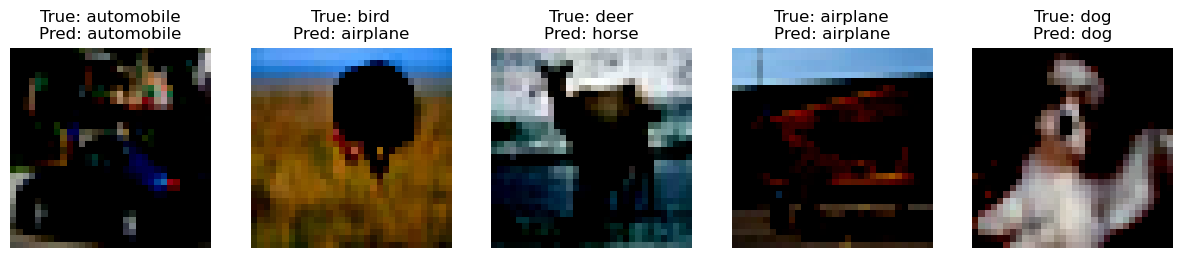

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to display random images with predictions
def display_random_samples(model, test_loader, criterion, num_samples=5):
    model.eval()
    classes = test_loader.dataset.classes
    random_idx = np.random.choice(len(test_loader.dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_idx):
        image, label = test_loader.dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension

        # Get model prediction
        with torch.no_grad():
            embeddings = model(image)
            logits = torch.matmul(embeddings, criterion.weight.T)
            prediction = torch.argmax(logits, dim=1).item()

        # Display image and prediction
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.squeeze(0).cpu().permute(1, 2, 0))
        plt.title(f"True: {classes[label]}\nPred: {classes[prediction]}")
        plt.axis('off')

    plt.show()

# Display random samples with accuracy
display_random_samples(model, test_loader, criterion, num_samples=5)


# Arc Loss

Training with ArcFace Loss:
Epoch: 1, Loss: 1.8811
Epoch: 2, Loss: 0.6599
Epoch: 3, Loss: 0.5122
Epoch: 4, Loss: 0.4291
Epoch: 5, Loss: 0.3783
Epoch: 6, Loss: 0.3345
Epoch: 7, Loss: 0.3070
Epoch: 8, Loss: 0.2556
Epoch: 9, Loss: 0.2253
Epoch: 10, Loss: 0.2107
Accuracy: 97.86%


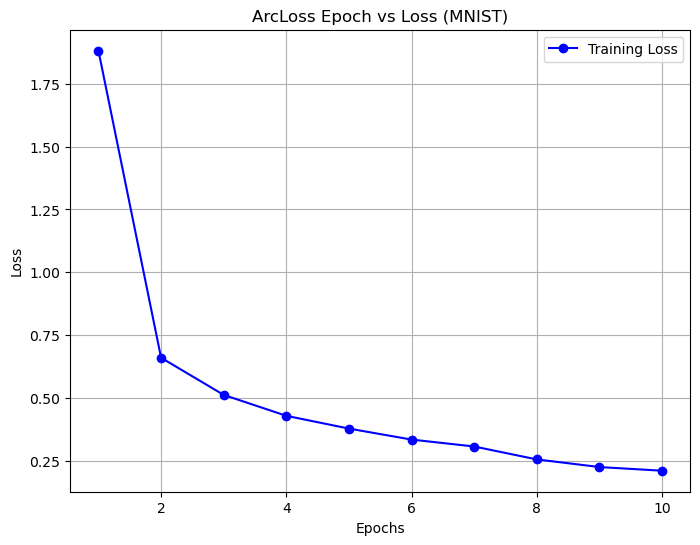


ArcFace Model Accuracy: 97.86%


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 1. Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define a CNN architecture with 128-d feature output for ArcFace
class ArcFaceCNN(nn.Module):
    def __init__(self, feature_dim=128):
        super(ArcFaceCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, feature_dim)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        features = torch.relu(self.fc1(x))
        return features

# 3. Define the ArcFace Loss class
class ArcFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=0.50, feature_dim=128, num_classes=10):
        super(ArcFaceLoss, self).__init__()
        self.s = s  # Scaling factor
        self.m = m  # Angular margin
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, feature_dim))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, features, labels):
        # Compute cosine similarity between features and weights
        cosine = torch.mm(features, self.weight.t())
        cosine = torch.clamp(cosine, -1.0, 1.0)

        # Apply margin to the target class
        phi = cosine - self.m
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1)

        # Combine modified and unmodified cosine similarities
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s  # Scale the logits
        return output

# 4. Initialize the model, loss function, and optimizer
arcface_model = ArcFaceCNN(feature_dim=128)
arcface_loss = ArcFaceLoss()
optimizer = optim.Adam(arcface_model.parameters(), lr=0.001)

# Variable to store ArcLoss data (epoch, loss)
ArcLoss_MNIST = []  # List to store (epoch, loss) for each epoch

# 5. Training function with loss tracking
def train_arcface(model, loss_fn, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            features = model(images)  # Extract features
            outputs = loss_fn(features, labels)  # Compute ArcFace logits
            loss = nn.CrossEntropyLoss()(outputs, labels)  # Apply cross-entropy loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Store loss for each epoch in ArcLoss_MNIST
        ArcLoss_MNIST.append((epoch + 1, total_loss / len(train_loader)))  # Store (epoch, loss)
        print(f"Epoch: {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

    return ArcLoss_MNIST

# 6. Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            features = model(images)  # Extract features
            outputs = arcface_loss(features, labels)  # Compute ArcFace logits
            _, predicted = torch.max(outputs, 1)  # Predict labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# 7. Train and evaluate the ArcFace model
print("Training with ArcFace Loss:")
epoch_losses = train_arcface(arcface_model, arcface_loss, train_loader, optimizer, epochs=10)
arcface_accuracy = evaluate(arcface_model, test_loader)

# 8. Plotting Epoch vs Loss
plt.figure(figsize=(8, 6))
epochs, losses = zip(*ArcLoss_MNIST)  # Unzip the list of (epoch, loss) into two separate lists
plt.plot(epochs, losses, marker='o', color='b', label='Training Loss')
plt.title('ArcLoss Epoch vs Loss (MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# 9. Print the final accuracy
print(f"\nArcFace Model Accuracy: {arcface_accuracy:.2f}%")


Training with ArcFace Loss:
Epoch 1, Loss: 5.5885
Epoch 2, Loss: 4.4139
Epoch 3, Loss: 3.8065
Epoch 4, Loss: 3.4054
Epoch 5, Loss: 3.0815
Epoch 6, Loss: 2.8265
Epoch 7, Loss: 2.5916
Epoch 8, Loss: 2.3884
Epoch 9, Loss: 2.1897
Epoch 10, Loss: 2.0104
Epoch 11, Loss: 1.8609
Epoch 12, Loss: 1.6894
Epoch 13, Loss: 1.5245
Epoch 14, Loss: 1.3946
Epoch 15, Loss: 1.2451
Epoch 16, Loss: 1.1470
Epoch 17, Loss: 1.0193
Epoch 18, Loss: 0.8949
Epoch 19, Loss: 0.7983
Epoch 20, Loss: 0.7240
Accuracy: 62.35%


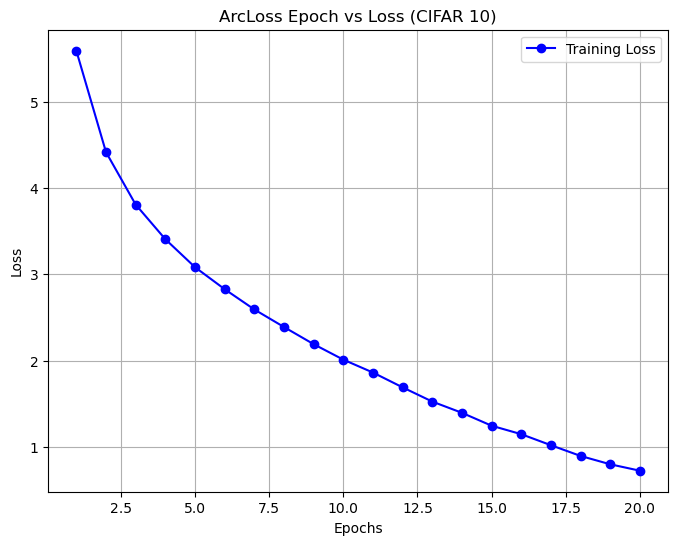


ArcFace Model Accuracy on CIFAR-10: 62.35%


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 1. Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB channels
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define the CNN architecture for CIFAR-10
class ArcFaceCNN_CIFAR10(nn.Module):
    def __init__(self, feature_dim=128):
        super(ArcFaceCNN_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # 3 input channels (RGB)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Added layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, feature_dim)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))  # Additional convolutional layer
        x = x.view(-1, 256 * 4 * 4)  # Flatten the tensor
        features = torch.relu(self.fc1(x))
        return features

# 3. Define the ArcFace Loss class
class ArcFaceLoss(nn.Module):
    def __init__(self, s=10.0, m=0.50, feature_dim=128, num_classes=10):
        super(ArcFaceLoss, self).__init__()
        self.s = s  # Scaling factor
        self.m = m  # Angular margin
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, feature_dim))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, features, labels):
        # Compute cosine similarity between features and weights
        cosine = torch.mm(features, self.weight.t())
        cosine = torch.clamp(cosine, -1.0, 1.0)

        # Apply margin to the target class
        phi = cosine - self.m
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1)

        # Combine modified and unmodified cosine similarities
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s  # Scale the logits
        return output

# 4. Initialize the model, loss function, and optimizer
arcface_model = ArcFaceCNN_CIFAR10(feature_dim=128)
arcface_loss = ArcFaceLoss()
optimizer = optim.Adam(arcface_model.parameters(), lr=0.0001)

# Variable to store ArcLoss data (epoch, loss)
ArcLoss_CIFAR10 = []  # List to store (epoch, loss) for each epoch

# 5. Training function with loss tracking
def train_arcface(model, loss_fn, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            features = model(images)  # Extract features
            outputs = loss_fn(features, labels)  # Compute ArcFace logits
            loss = nn.CrossEntropyLoss()(outputs, labels)  # Apply cross-entropy loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Store loss for each epoch in ArcLoss_CIFAR10
        ArcLoss_CIFAR10.append((epoch + 1, total_loss / len(train_loader)))  # Store (epoch, loss)
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

    return ArcLoss_CIFAR10

# 6. Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            features = model(images)  # Extract features
            outputs = arcface_loss(features, labels)  # Compute ArcFace logits
            _, predicted = torch.max(outputs, 1)  # Predict labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# 7. Train and evaluate the ArcFace model
print("Training with ArcFace Loss:")
epoch_losses = train_arcface(arcface_model, arcface_loss, train_loader, optimizer, epochs=20)  # Increased epochs for CIFAR-10
arcface_accuracy = evaluate(arcface_model, test_loader)

# 8. Plotting Epoch vs Loss
plt.figure(figsize=(8, 6))
epochs, losses = zip(*ArcLoss_CIFAR10)  # Unzip the list of (epoch, loss) into two separate lists
plt.plot(epochs, losses, marker='o', color='b', label='Training Loss')
plt.title('ArcLoss Epoch vs Loss (CIFAR 10)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# 9. Print the final accuracy
print(f"\nArcFace Model Accuracy on CIFAR-10: {arcface_accuracy:.2f}%")


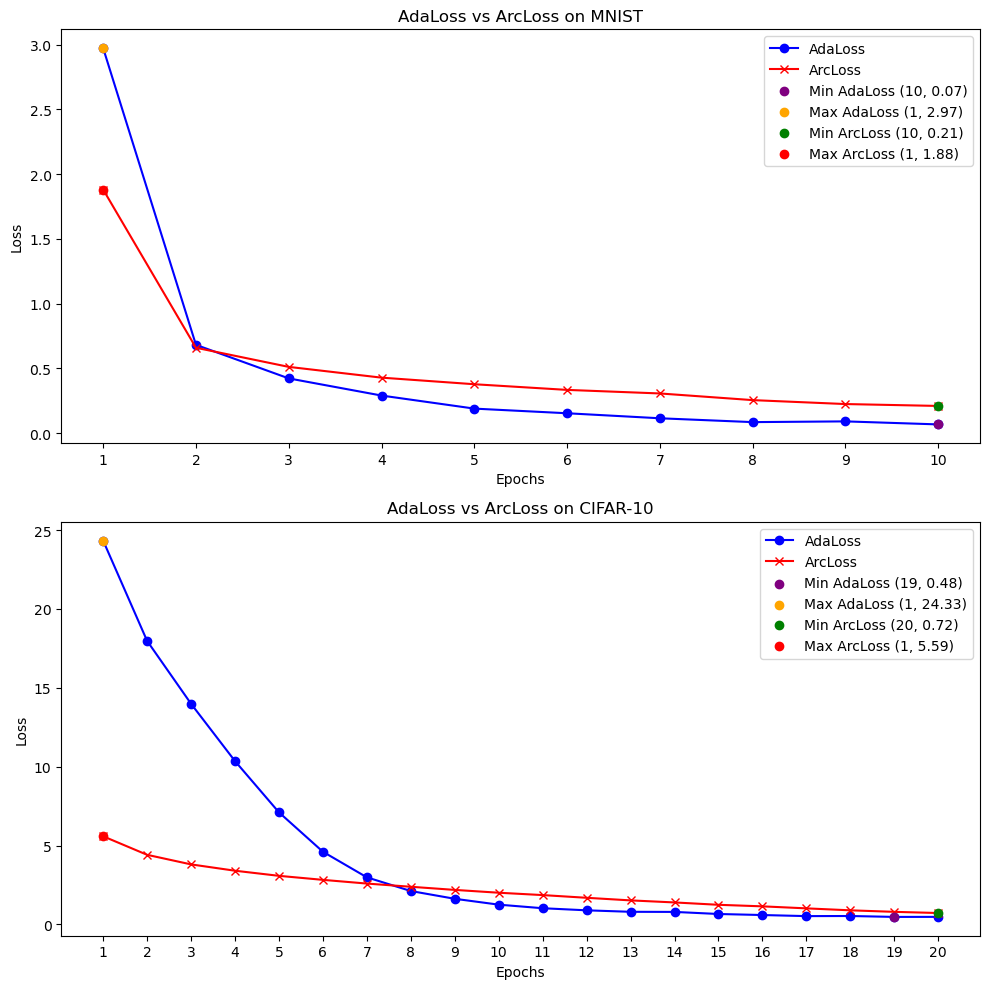

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract epochs and loss values for MNIST
epochs_mnist, AdaLoss_MNIST_vals = zip(*AdaLoss_MNIST)  # Unpack tuples into two lists
_, ArcLoss_MNIST_vals = zip(*ArcLoss_MNIST)

# Extract epochs and loss values for CIFAR-10
epochs_cifar10, AdaLoss_CIFAR10_vals = zip(*AdaLoss_CIFAR10)
_, ArcLoss_CIFAR10_vals = zip(*ArcLoss_CIFAR10)

# Find min and max loss values for both AdaLoss and ArcLoss for MNIST
min_loss_ada_mnist = min(AdaLoss_MNIST_vals)
max_loss_ada_mnist = max(AdaLoss_MNIST_vals)

min_loss_arc_mnist = min(ArcLoss_MNIST_vals)
max_loss_arc_mnist = max(ArcLoss_MNIST_vals)

# Find the epochs corresponding to the min and max loss values for MNIST
min_epoch_ada_mnist = epochs_mnist[AdaLoss_MNIST_vals.index(min_loss_ada_mnist)]
max_epoch_ada_mnist = epochs_mnist[AdaLoss_MNIST_vals.index(max_loss_ada_mnist)]

min_epoch_arc_mnist = epochs_mnist[ArcLoss_MNIST_vals.index(min_loss_arc_mnist)]
max_epoch_arc_mnist = epochs_mnist[ArcLoss_MNIST_vals.index(max_loss_arc_mnist)]

# Find min and max loss values for both AdaLoss and ArcLoss for CIFAR-10
min_loss_ada_cifar10 = min(AdaLoss_CIFAR10_vals)
max_loss_ada_cifar10 = max(AdaLoss_CIFAR10_vals)

min_loss_arc_cifar10 = min(ArcLoss_CIFAR10_vals)
max_loss_arc_cifar10 = max(ArcLoss_CIFAR10_vals)

# Find the epochs corresponding to the min and max loss values for CIFAR-10
min_epoch_ada_cifar10 = epochs_cifar10[AdaLoss_CIFAR10_vals.index(min_loss_ada_cifar10)]
max_epoch_ada_cifar10 = epochs_cifar10[AdaLoss_CIFAR10_vals.index(max_loss_ada_cifar10)]

min_epoch_arc_cifar10 = epochs_cifar10[ArcLoss_CIFAR10_vals.index(min_loss_arc_cifar10)]
max_epoch_arc_cifar10 = epochs_cifar10[ArcLoss_CIFAR10_vals.index(max_loss_arc_cifar10)]

# Plotting AdaLoss vs ArcLoss for MNIST
plt.figure(figsize=(10, 10))

# Line chart for MNIST
plt.subplot(2, 1, 1)
plt.plot(epochs_mnist, AdaLoss_MNIST_vals, label='AdaLoss', marker='o', color='b')
plt.plot(epochs_mnist, ArcLoss_MNIST_vals, label='ArcLoss', marker='x', color='r')

# Highlight min and max values for AdaLoss and ArcLoss for MNIST
plt.scatter(min_epoch_ada_mnist, min_loss_ada_mnist, color='purple', zorder=5, label=f'Min AdaLoss ({min_epoch_ada_mnist}, {min_loss_ada_mnist:.2f})')
plt.scatter(max_epoch_ada_mnist, max_loss_ada_mnist, color='orange', zorder=5, label=f'Max AdaLoss ({max_epoch_ada_mnist}, {max_loss_ada_mnist:.2f})')

plt.scatter(min_epoch_arc_mnist, min_loss_arc_mnist, color='green', zorder=5, label=f'Min ArcLoss ({min_epoch_arc_mnist}, {min_loss_arc_mnist:.2f})')
plt.scatter(max_epoch_arc_mnist, max_loss_arc_mnist, color='red', zorder=5, label=f'Max ArcLoss ({max_epoch_arc_mnist}, {max_loss_arc_mnist:.2f})')

plt.title('AdaLoss vs ArcLoss on MNIST')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_mnist)  # Ensures all epoch values are used as x-ticks
plt.legend()

# Line chart for CIFAR-10
plt.subplot(2, 1, 2)
plt.plot(epochs_cifar10, AdaLoss_CIFAR10_vals, label='AdaLoss', marker='o', color='b')
plt.plot(epochs_cifar10, ArcLoss_CIFAR10_vals, label='ArcLoss', marker='x', color='r')

# Highlight min and max values for AdaLoss and ArcLoss for CIFAR-10
plt.scatter(min_epoch_ada_cifar10, min_loss_ada_cifar10, color='purple', zorder=5, label=f'Min AdaLoss ({min_epoch_ada_cifar10}, {min_loss_ada_cifar10:.2f})')
plt.scatter(max_epoch_ada_cifar10, max_loss_ada_cifar10, color='orange', zorder=5, label=f'Max AdaLoss ({max_epoch_ada_cifar10}, {max_loss_ada_cifar10:.2f})')

plt.scatter(min_epoch_arc_cifar10, min_loss_arc_cifar10, color='green', zorder=5, label=f'Min ArcLoss ({min_epoch_arc_cifar10}, {min_loss_arc_cifar10:.2f})')
plt.scatter(max_epoch_arc_cifar10, max_loss_arc_cifar10, color='red', zorder=5, label=f'Max ArcLoss ({max_epoch_arc_cifar10}, {max_loss_arc_cifar10:.2f})')

plt.title('AdaLoss vs ArcLoss on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_cifar10)  # Ensures all epoch values are used as x-ticks
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
